In [11]:
import uproot
import uproot_methods

import awkward

# Histogram section
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

#file = 'merge.root'
file = '*.root'

In [12]:
def particle_selection(hlt, save_name, year):
    
    # Histogram definition
    
    # Dimuon
    hist_dimuon = bh.Histogram(bh.axis.Regular(100, 0, 50, metadata=r"$p_{T,\mu^+\mu^-}$ [GeV]"),
                                 bh.axis.Regular(80, -4.0, 4.0, metadata=r"$\eta_{\mu^+\mu^-}$"),
                                 bh.axis.Regular(70, -3.5, 3.5, metadata=r"$\phi_{\mu^+\mu^-}$"),)
    
    # Quarkonia
    hist_quarkonia_mass_trigger = bh.Histogram(bh.axis.Regular(100, 2, 4, metadata=r"$m_{\mu^+\mu^-}$ [GeV]"))
    
    # D0
    hist_d0_mass_trigger = bh.Histogram(bh.axis.Regular(100, 0.6, 3.2, metadata=r"$m_{D^0}$ [GeV]"))
    hist_d0 = bh.Histogram(bh.axis.Regular(100, 0, 50, metadata=r"$p_{T,D^0}$ [GeV]"),
                                 bh.axis.Regular(80, -4.0, 4.0, metadata=r"$\eta_{D^0}$"),
                                 bh.axis.Regular(70, -3.5, 3.5, metadata=r"$\phi_{D^0}$"),)
    
    trigger = np.array([])
    # Muon selection
    branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_isGlobal', 'Muon_softId', 'Muon_vtxIdx' , 'Muon_x', 'Muon_y', 'Muon_z'
                    ,'nD0', 'D0_pt', 'D0_eta', 'D0_phi', 'D0_mass12', 'D0_vtxIdx', 'D0_x', 'D0_y', 'D0_z', hlt]
    for chunk in uproot.iterate(file, 'Events', branches=branches, entrysteps=500000, namedecode='ascii'):
        Muon = JaggedCandidateArray.candidatesfromcounts(chunk['nMuon'],
                                                pt=chunk['Muon_pt'].content,
                                                eta=chunk['Muon_eta'].content,
                                                phi=chunk['Muon_phi'].content,
                                                mass=chunk['Muon_mass'].content,
                                                charge=chunk['Muon_charge'].content,
                                                isGlobal=chunk['Muon_isGlobal'].content,
                                                softId=chunk['Muon_softId'].content,   
                                                vtxIdx=chunk['Muon_vtxIdx'].content,
                                                x=chunk['Muon_x'].content,
                                                y=chunk['Muon_y'].content,
                                                z=chunk['Muon_z'].content,
                                                          
                                               )
        D0 = JaggedCandidateArray.candidatesfromcounts(chunk['nD0'],
                                                    pt=chunk['D0_pt'].content,
                                                    eta=chunk['D0_eta'].content,
                                                    phi=chunk['D0_phi'].content,
                                                    mass=chunk['D0_mass12'].content,
                                                    vtxIdx=chunk['D0_vtxIdx'].content,
                                                    x=chunk['D0_x'].content,
                                                    y=chunk['D0_y'].content,
                                                    z=chunk['D0_z'].content,)
    
        trigger = np.where(chunk[hlt] > 0, True, False)        
        
        Muon = Muon[trigger]
        D0 = D0[trigger]

        # Basic muon cuts.

        # Soft id cut
        soft_id = (Muon.softId > 0)
        Muon = Muon[soft_id]

        # Global cut
        global_muon = (Muon.isGlobal > 0)
        Muon = Muon[global_muon]

        # pT cuts
        pt_cut = (Muon.pt > 3)
        Muon = Muon[pt_cut]

        # eta_cut
        eta_cut = (np.absolute(Muon.eta) <= 2.4)
        Muon = Muon[eta_cut]

        # Dimuons cuts

        Dimuon_ = (Muon.counts > 1)
        Muon = Muon[Dimuon_]

        D0 = D0[Dimuon_]

        Dimuon = Muon.distincts()

        # Charge and vertex cuts

        opposite_charge = (Dimuon.i0['charge'] * Dimuon.i1['charge'] < 0)
        Dimuon = Dimuon[opposite_charge]

        same_vtx = (Dimuon.i0['vtxIdx'] == Dimuon.i1['vtxIdx']) | (np.absolute(Dimuon.i0['z'] - Dimuon.i1['z']) < 0.2)
        Dimuon = Dimuon[same_vtx]

        # Only events with at least 1 dimuon
        evtcut = (Dimuon.counts > 0)
        Dimuon = Dimuon[evtcut]

        D0 = D0[evtcut]

        # Quarkonia selection
        Dimuon_mass_quarkonia = ((Dimuon.mass > 2.95) & (Dimuon.mass < 3.25))
        quarkonia = Dimuon[Dimuon_mass_quarkonia]
        
        ################## Filling histograms ##################
        
        hist_dimuon.fill(quarkonia.pt.flatten(), quarkonia.eta.flatten(), quarkonia.phi.flatten())
        
        hist_quarkonia_mass_trigger.fill(quarkonia.mass.flatten())
        
        hist_d0_mass_trigger.fill(D0.mass.flatten())
        
        hist_d0.fill(D0.pt.flatten(), D0.eta.flatten(), D0.phi.flatten())
        
        
        # Calls plots
        generate_plot(hist_dimuon[:, sum, sum], "dimuon pT plot - " + save_name, year)
        generate_plot(hist_dimuon[sum, :, sum], "dimuon eta plot - " + save_name, year)
        generate_plot(hist_dimuon[sum, sum, :], "dimuon phi plot - " + save_name, year)
        
        generate_plot(hist_quarkonia_mass_trigger, "jpsi mass plot - " + save_name, year)
        
        generate_plot(hist_d0_mass_trigger, "D0 mass plot - " + save_name, year)
        generate_plot(hist_d0[:, sum, sum], "D0 pT plot - " + save_name, year)
        generate_plot(hist_d0[sum, :, sum], "D0 eta plot - " + save_name, year)
        generate_plot(hist_d0[sum, sum, :], "D0 phi plot - " + save_name, year)
    

In [13]:
def generate_plot(hist, save_name, year): 
    
    
    ax = plt.gca()
    
    ax.set_xlabel(hist.axes[0].metadata, loc='right')
    ax.set_ylabel("Counts", loc='top')

    mean = (hist.view() * hist.axes[0].centers).sum()/hist.sum()
    std = np.sqrt((hist.view()*((hist.axes[0].centers - mean)**2)).sum()/hist.sum())

    hep.histplot(hist, ax=ax)

    annotation = f"Total {hist.sum()}" \
               + "\n" + f"Mean: {round(mean,2)}" \
               + "\n" + f"Std: {round(std,2)}"
    ax.annotate(annotation, xy=(0.85, 0.85), xycoords='axes fraction', fontsize = "small",
               ha='center', annotation_clip=False, bbox=dict(boxstyle='round', fc='None'))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)

    fig = ax.get_figure()

    fig.savefig("hlt_choice_" + year + "/" + save_name)

    ax.clear()
    
    
    

In [14]:
def charmonium_trigger(year):
    import os, sys, subprocess
    
    os.system("rm -rf hlt_choice_" + year)
    os.system("mkdir -p hlt_choice_" + year)
    
    
    # 2017 HLT path
    if year == "2017":
        particle_selection("HLT_Dimuon0_Jpsi_L1_4R_0er1p5R", "HLT_Dimuon0_Jpsi_L1_4R_0er1p5R", year)
        particle_selection("HLT_Dimuon0_Jpsi_L1_NoOS", "HLT_Dimuon0_Jpsi_L1_NoOS", year)   
        particle_selection("HLT_Dimuon0_Jpsi", "HLT_Dimuon0_Jpsi", year)
        particle_selection("HLT_Dimuon0_LowMass_L1_0er1p5", "HLT_Dimuon0_LowMass_L1_0er1p5", year)
        particle_selection("HLT_Dimuon0_LowMass_L1_4", "HLT_Dimuon0_LowMass_L1_4", year)
        particle_selection("HLT_Dimuon0_LowMass", "HLT_Dimuon0_LowMass", year)
        particle_selection("HLT_Dimuon20_Jpsi_Barrel_Seagulls", "HLT_Dimuon20_Jpsi_Barrel_Seagulls", year)
        particle_selection("HLT_Dimuon25_Jpsi_noCorrL1", "HLT_Dimuon25_Jpsi_noCorrL1", year)
        particle_selection("HLT_Dimuon25_Jpsi" ,"HLT_Dimuon25_Jpsi", year)
        #particle_selection("HLT_DoubleMu4_3_Jpsi", "HLT_DoubleMu4_3_Jpsi", year)
        particle_selection("HLT_DoubleMu4_Jpsi_Displaced", "HLT_DoubleMu4_Jpsi_Displaced", year)
    
    

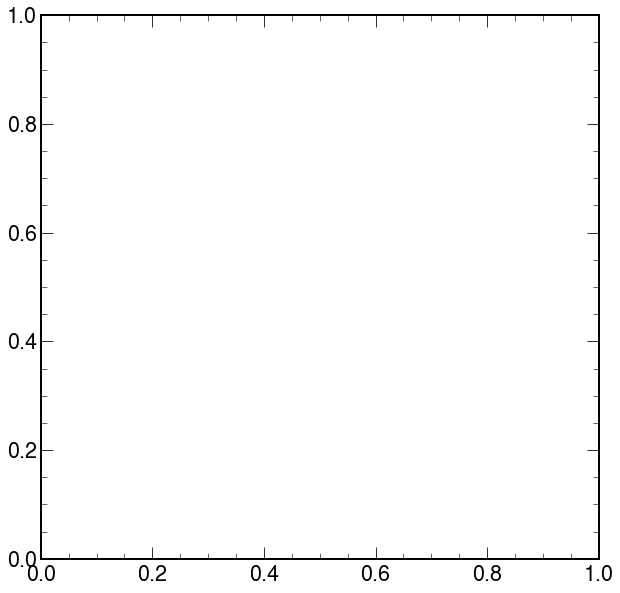

In [15]:
charmonium_trigger("2017")